In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import ticker
rcParams["figure.figsize"] = (10,8)
plt.style.use("science")
import eispac
from glob import glob
import sunpy
from sunpy.io.special import read_genx
import cmcrameri.cm as cmcm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
from scipy import interpolate
from scipy import ndimage
import juanfit
from juanfit import SpectrumFitSingle, SpectrumFitRow
rcParams['axes.labelsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 18
rcParams['figure.figsize'] = [10,10]
rcParams['axes.linewidth'] = 2
rcParams['axes.titlesize'] = 18
from scipy.interpolate import interp1d
import astropy.constants as const


In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
data_filepath = '../../src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5'
fe_10_184_fit_file = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5"
fe_12_195_fit_file = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_12_195_119.2c-0.fit.h5"


Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


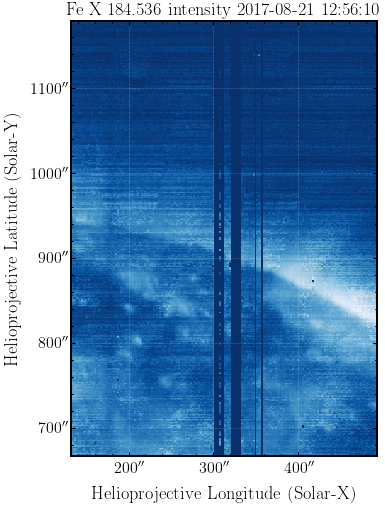

In [4]:
fe_10_184_fit_res = eispac.read_fit(fe_10_184_fit_file)
fe_10_184_inten_map = fe_10_184_fit_res.get_map(component=0, measurement='intensity')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_10_184_inten_map)
fe_10_184_inten_map.plot(axes=ax)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


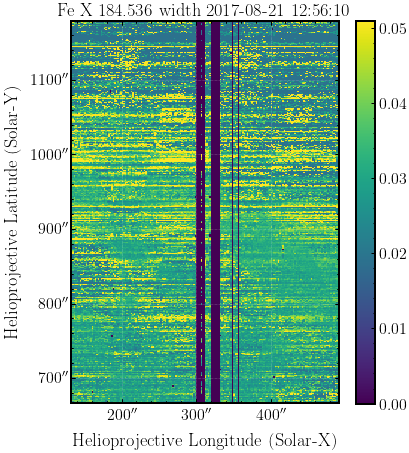

In [5]:
fe_10_184_width_map = fe_10_184_fit_res.get_map(0, 'width')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_10_184_width_map)
fe_10_184_width_map.plot(axes=ax)
plt.colorbar(ax=ax,shrink=0.88)

Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_12_195_119.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


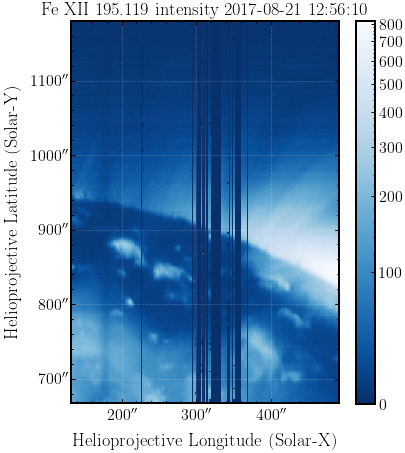

In [6]:
fe_12_195_fit_res = eispac.read_fit(fe_12_195_fit_file)
fe_12_195_inten_map = fe_12_195_fit_res.get_map(component=0, measurement='intensity')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_12_195_inten_map)
fe_12_195_inten_map.plot(axes=ax)
plt.colorbar(ax=ax,shrink=0.88)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


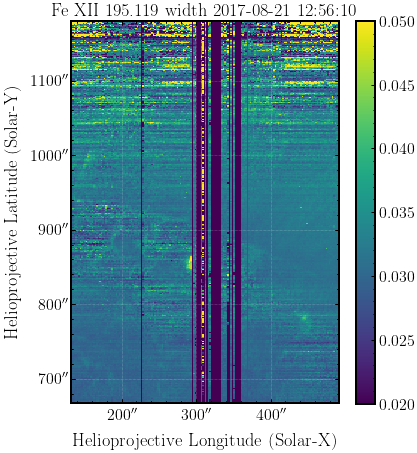

In [7]:
fe_12_195_width_map = fe_12_195_fit_res.get_map(0, 'width')
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(projection=fe_12_195_width_map)
fe_12_195_width_map.plot_settings['norm'] = ImageNormalize(vmin=0.02, vmax=0.05)
fe_12_195_width_map.plot(axes=ax)

plt.colorbar(ax=ax,shrink=0.88)

In [18]:
fe_10_184_fit_res.meta['index']

{'achf_ver': 1,
 'asrcdir': 0,
 'asrcnr': 0,
 'asrcskip': 0,
 'bitc_ver': 7,
 'bitpix': 8,
 'cal_abs': 0,
 'cal_cr': 0,
 'cal_dc': 0,
 'cal_dp': 0,
 'cal_hp': 0,
 'cal_phot': 0,
 'cal_reta': 0,
 'ccdxl': 2148,
 'ccsds_en': '2017-08-21T14:44:19.000',
 'ccsds_ob': '2017-08-21T11:09:37.000',
 'ccsds_ti': 2433047213,
 'cdelt1': -1.9968,
 'cdelt2': 1.0,
 'cdelt3': 0.0223,
 'cmirr': 47659,
 'comment': array(['This FITS file may contain long string keyword values that are',
        "continued over multiple keywords.  This convention uses the  '",
        'character at the end of a string which is then continued',
        "on subsequent keywords whose name = 'CONTINUE'.", '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
       dtype='<U63'),
 'compmod': 3,
 'crota1': 0.0,
 'crota2': 0.0,
 'crpix1': 1,
 'crpix2': 1,
 'crval1': 475.454,
 'crval2': 663.18,
 'ctype1': 'Solar-X',
 'ctype2': 'Solar-Y',
 'ctype3': 'Wavelength',
 'cunit1': 'arcsec',
 'cunit2

In [16]:
fe_12_195_fit_res.meta['extent_arcsec']

[133.7651777267456, 493.1891679763794, 667.869140625, 1179.869140625]